In [13]:
from __future__ import unicode_literals
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import itertools
from math import factorial
import datetime
import math
from scipy import signal
import pandas as pd
from scipy.signal import hilbert, chirp

In [14]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T


def util_pattern_space(time_series, lag, dim):
    """Create a set of sequences with given lag and dimension
    Args:
       time_series: Vector or string of the sample data
       lag: Lag between beginning of sequences
       dim: Dimension (number of patterns)
    Returns:
        2D array of vectors
    """
    n = len(time_series)

    if lag * dim > n:
        raise Exception('Result matrix exceeded size limit, try to change lag or dim.')
    elif lag < 1:
        raise Exception('Lag should be greater or equal to 1.')

    pattern_space = np.empty((n - lag * (dim - 1), dim))
    for i in range(n - lag * (dim - 1)):
        for j in range(dim):
            pattern_space[i][j] = time_series[i + j * lag]

    return pattern_space


def util_standardize_signal(time_series):
    return (time_series - np.mean(time_series)) / np.std(time_series)


def util_granulate_time_series(time_series, scale):
    """Extract coarse-grained time series
    Args:
        time_series: Time series
        scale: Scale factor
    Returns:
        Vector of coarse-grained time series with given scale factor
    """
    n = len(time_series)
    b = int(np.fix(n / scale))
    temp = np.reshape(time_series[0:b*scale], (b, scale))
    cts = np.mean(temp, axis = 1)
    return cts


def shannon_entropy(time_series):
    """Return the Shannon Entropy of the sample data.
    Args:
        time_series: Vector or string of the sample data
    Returns:
        The Shannon Entropy as float value
    """

    # Check if string
    if not isinstance(time_series, str):
        time_series = list(time_series)

    # Create a frequency data
    data_set = list(set(time_series))
    freq_list = []
    for entry in data_set:
        counter = 0.
        for i in time_series:
            if i == entry:
                counter += 1
        freq_list.append(float(counter) / len(time_series))

    # Shannon entropy
    ent = 0.0
    for freq in freq_list:
        ent += freq * np.log2(freq)
    ent = -ent
    return ent


def sample_entropy(time_series, sample_length, tolerance = None):
    """Calculates the sample entropy of degree m of a time_series.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        time_series: numpy array of time series
        sample_length: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(time_series)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'sample_length' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = sample_length - 1;

    time_series = np.array(time_series)
    if tolerance is None:
        tolerance = 0.1*np.std(time_series)

    n = len(time_series)

    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2


    for i in range(n - M - 1):
        template = time_series[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_time_series = time_series[i+1:]

        searchlist = np.nonzero(np.abs(rem_time_series - template[0]) < tolerance)[0]

        go = len(searchlist) > 0;

        length = 1;

        Ntemp[length] += len(searchlist)

        while go:
            length += 1
            nextindxlist = searchlist + 1;
            nextindxlist = nextindxlist[nextindxlist < n - 1 - i]#Remove candidates too close to the end
            nextcandidates = rem_time_series[nextindxlist]
            hitlist = np.abs(nextcandidates - template[length-1]) < tolerance
            searchlist = nextindxlist[hitlist]

            Ntemp[length] += np.sum(hitlist)

            go = any(hitlist) and length < M + 1


    sampen =  - np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen


def multiscale_entropy(time_series, sample_length, tolerance = None, maxscale = None):
    """Calculate the Multiscale Entropy of the given time series considering
    different time-scales of the time series.
    Args:
        time_series: Time series for analysis
        sample_length: Bandwidth or group of points
        tolerance: Tolerance (default = 0.1*std(time_series))
    Returns:
        Vector containing Multiscale Entropy
    Reference:
        [1] http://en.pudn.com/downloads149/sourcecode/math/detail646216_en.html
    """

    if tolerance is None:
        #we need to fix the tolerance at this level. If it remains 'None' it will be changed in call to sample_entropy()
        tolerance = 0.5*np.std(time_series) #originally defaulted at 0.1 but can be changed to 0.25
    if maxscale is None:
        maxscale = len(time_series)

    mse = np.zeros(maxscale)

    for i in range(maxscale): #skip every 20, less resolution but faster processing 
        now = datetime.datetime.now()
        if i == 0:
            print(now.strftime("%H:%M:%S"))
        elif i % 10 == 0:
            print(now.strftime("%H:%M:%S"))
        #print('index', i)
        temp = util_granulate_time_series(time_series, i+1)
        #print('granulated', i)
        mse[i] = sample_entropy(temp, sample_length, tolerance)[-1]
        #print('samp_ent', i)
    return mse


def permutation_entropy(time_series, order=3, delay=1, normalize=False):
    """Permutation Entropy.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    References
    ----------
    .. [1] Massimiliano Zanin et al. Permutation Entropy and Its Main
        Biomedical and Econophysics Applications: A Review.
        http://www.mdpi.com/1099-4300/14/8/1553/pdf
    .. [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural
        complexity measure for time series.
        http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
    Notes
    -----
    Last updated (Oct 2018) by Raphael Vallat (raphaelvallat9@gmail.com):
    - Major speed improvements
    - Use of base 2 instead of base e
    - Added normalization
    Examples
    --------
    1. Permutation entropy with order 2
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value between 0 and log2(factorial(order))
        >>> print(permutation_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(permutation_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def multiscale_permutation_entropy(time_series, m, delay, scale):
    """Calculate the Multiscale Permutation Entropy
    Args:
        time_series: Time series for analysis
        m: Order of permutation entropy
        delay: Time delay
        scale: Scale factor
    Returns:
        Vector containing Multiscale Permutation Entropy
    Reference:
        [1] Francesco Carlo Morabito et al. Multivariate Multi-Scale Permutation Entropy for
            Complexity Analysis of Alzheimer’s Disease EEG. www.mdpi.com/1099-4300/14/7/1186
        [2] http://www.mathworks.com/matlabcentral/fileexchange/37288-multiscale-permutation-entropy-mpe/content/MPerm.m
    """
    mspe = []
    for i in range(scale):
        coarse_time_series = util_granulate_time_series(time_series, i + 1)
        pe = permutation_entropy(coarse_time_series, order=m, delay=delay)
        mspe.append(pe)
    return mspe


# TODO add tests
def composite_multiscale_entropy(time_series, sample_length, scale, tolerance=None):
    """Calculate the Composite Multiscale Entropy of the given time series.
    Args:
        time_series: Time series for analysis
        sample_length: Number of sequential points of the time series
        scale: Scale factor
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Composite Multiscale Entropy
    Reference:
        [1] Wu, Shuen-De, et al. "Time series analysis using
            composite multiscale entropy." Entropy 15.3 (2013): 1069-1084.
    """
    cmse = np.zeros((1, scale))

    for i in range(scale):
        for j in range(i):
            tmp = util_granulate_time_series(time_series[j:], i + 1)
            cmse[i] += sample_entropy(tmp, sample_length, tolerance) / (i + 1)
    return cmse

In [15]:
a1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/BerliozSymphResamp.wav")
arr1 = np.array(a1[1],dtype=float)
arr1 = np.mean(arr1,axis=1)

a2 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/CalvinHarrisResamp.wav")
arr2 = np.array(a2[1],dtype=float)
arr2 = np.mean(arr2,axis=1)

a3 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/HermitThrushResamp.wav")
arr3 = np.array(a3[1],dtype=float)
arr3 = np.mean(arr3,axis=1)

a4 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/TEDSynthResamp.wav")
arr4 = np.array(a4[1],dtype=float)
#arr4 = np.mean(arr4,axis=1)

a5 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/TEDTalkResamp.wav")
arr5 = np.array(a5[1],dtype=float)
arr5 = np.mean(arr5,axis=1)

In [16]:
amp1 = np.abs(hilbert(arr1))
amp2 = np.abs(hilbert(arr2))
amp3 = np.abs(hilbert(arr3))
amp4 = np.abs(hilbert(arr4))
amp5 = np.abs(hilbert(arr5))


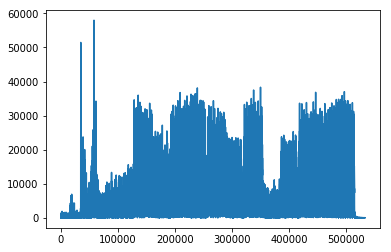

In [39]:
plt.plot(range(len(amp2)),amp2)

In [20]:
samp1_mse = multiscale_entropy(amp1[0:143437], 3, None, 100)
samp2_mse = multiscale_entropy(amp2[0:143437], 3, None, 100)
samp3_mse = multiscale_entropy(amp3[0:143437], 3, None, 100)
samp4_mse = multiscale_entropy(amp4[0:143437], 3, None, 100)
samp5_mse = multiscale_entropy(amp5[0:143437], 3, None, 100)

12:14:47
12:18:35
12:18:44
12:18:48
12:18:51
12:18:53
12:18:54
12:18:55
12:18:56
12:18:57
12:18:57
12:22:13
12:22:22
12:22:25
12:22:28
12:22:29
12:22:31
12:22:32
12:22:32
12:22:33
12:22:34
12:25:51
12:26:03
12:26:09
12:26:12
12:26:14
12:26:16
12:26:18
12:26:19
12:26:20
12:26:20
12:30:49
12:30:59
12:31:04
12:31:07
12:31:09
12:31:10
12:31:11
12:31:12
12:31:13
12:31:14
12:34:47
12:34:55
12:34:59
12:35:01
12:35:03
12:35:04
12:35:05
12:35:06
12:35:07


Text(0.5, 1.0, '2048hz Amplitude MSE')

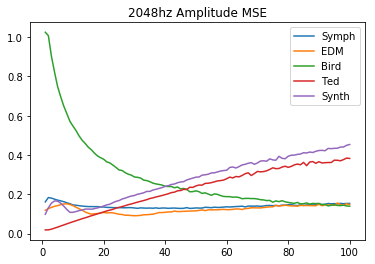

In [21]:
plt.plot(range(1,101),samp1_mse, range(1,101),samp2_mse,range(1,101),samp3_mse,range(1,101),samp4_mse,range(1,101),samp5_mse)
plt.legend(['Symph','EDM','Bird','Ted','Synth'])
plt.title('2048hz Amplitude MSE')

## EEG

In [22]:
##EDM##
cl3_edm = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_edm.csv",header=None)
cl4_edm = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_edm.csv",header=None)

In [27]:
cl3_mse = []
cl4_mse = []

for i in range(len(cl3_edm)):
    ts = cl3_edm.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl3_mse.append(multiscale_entropy( amp[0:halt], 3, None, 100))
    
for i in range(len(cl4_edm)):
    ts = cl4_edm.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl4_mse.append(multiscale_entropy( amp[0:halt], 3, None, 100))

14:22:14
14:22:52
14:22:55
14:22:56
14:22:57
14:22:58
14:22:58
14:22:59
14:22:59
14:22:59
14:23:00
14:23:36
14:23:39
14:23:40
14:23:41
14:23:42
14:23:42
14:23:43
14:23:43
14:23:43
14:23:44
14:24:24
14:24:27
14:24:29
14:24:29
14:24:30
14:24:31
14:24:31
14:24:31
14:24:32
14:24:32
14:25:15
14:25:18
14:25:19
14:25:20
14:25:21
14:25:21
14:25:22
14:25:22
14:25:22
14:25:23
14:26:01
14:26:03
14:26:05
14:26:05
14:26:06
14:26:07
14:26:07
14:26:07
14:26:08
14:26:08
14:26:44
14:26:47
14:26:48
14:26:49
14:26:50
14:26:50
14:26:51
14:26:51
14:26:51
14:26:52
14:27:30
14:27:33
14:27:35
14:27:36
14:27:36
14:27:37
14:27:37
14:27:37
14:27:38
14:27:38
14:28:20
14:28:23
14:28:24
14:28:25
14:28:26
14:28:26
14:28:27
14:28:27
14:28:27
14:28:28
14:29:07
14:29:10
14:29:12
14:29:13
14:29:13
14:29:14
14:29:14
14:29:15
14:29:15
14:29:15
14:29:57
14:30:00
14:30:02
14:30:02
14:30:03
14:30:04
14:30:04
14:30:05
14:30:05
14:30:05
14:30:43
14:30:47
14:30:48
14:30:49
14:30:50
14:30:50
14:30:51
14:30:51
14:30:52
14:30:52
1

In [40]:
cl3_mean = np.mean(cl3_mse, axis=0)
cl4_mean = np.mean(cl4_mse, axis=0)

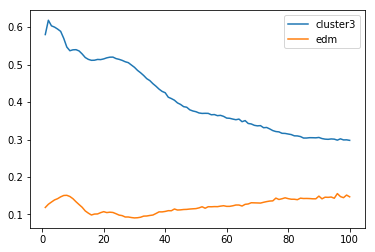

In [35]:
plt.plot(range(1,101),cl3_mean,range(1,101),samp2_mse)
plt.legend(['cluster3','edm'])

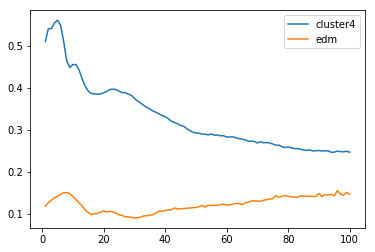

In [42]:
plt.plot(range(1,101),cl4_mean,range(1,101),samp2_mse)
plt.legend(['cluster4','edm'])

In [44]:
##Bird Song##
cl3_bird = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_hermit.csv",header=None)
cl4_bird = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_hermit.csv",header=None)

In [51]:
#cl3_birdmse = []
cl4_birdmse = []
#cl3_birdamp = []
cl4_birdamp = []

#for i in range(len(cl3_bird)):
    #ts = cl3_bird.loc[i,:].values
    #amp = np.abs(hilbert(ts))
    #halt = int(len(ts)/4)
    #cl3_birdamp.append(amp)
    #cl3_birdmse.append(multiscale_entropy( amp[0:halt], 3, None, 100))
    
for i in range(len(cl4_edm)):
    ts = cl4_bird.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl4_birdamp.append(amp)
    cl4_birdmse.append(multiscale_entropy( amp[0:halt], 3, None, 100))

16:51:34
16:52:12
16:52:15
16:52:16
16:52:17
16:52:18
16:52:18
16:52:19
16:52:19
16:52:20
16:52:20
16:53:04
16:53:07
16:53:08
16:53:09
16:53:09
16:53:10
16:53:10
16:53:11
16:53:11
16:53:11
16:53:54
16:53:57
16:53:59
16:54:00
16:54:00
16:54:01
16:54:01
16:54:02
16:54:02
16:54:02
16:54:49
16:54:52
16:54:54
16:54:55
16:54:55
16:54:56
16:54:56
16:54:57
16:54:57
16:54:57
16:55:35
16:55:38
16:55:39
16:55:40
16:55:40
16:55:41
16:55:41
16:55:42
16:55:42
16:55:42
16:56:18
16:56:20
16:56:21
16:56:22
16:56:23
16:56:23
16:56:24
16:56:24
16:56:24
16:56:25
16:57:05
16:57:08
16:57:09
16:57:10
16:57:11
16:57:12
16:57:12
16:57:12
16:57:13
16:57:13
16:57:51
16:57:54
16:57:55
16:57:56
16:57:56
16:57:57
16:57:57
16:57:58
16:57:58
16:57:58
16:58:36
16:58:39
16:58:41
16:58:42
16:58:42
16:58:43
16:58:43
16:58:44
16:58:44
16:58:44
16:59:23
16:59:26
16:59:28
16:59:29
16:59:30
16:59:30
16:59:31
16:59:31
16:59:31
16:59:32
17:00:15
17:00:17
17:00:19
17:00:20
17:00:20
17:00:21
17:00:21
17:00:22
17:00:22
17:00:22
1

In [52]:
cl3_birdmean = np.mean(cl3_birdmse, axis=0)
cl4_birdmean = np.mean(cl4_birdmse, axis=0)

Text(0.5, 1.0, 'Cluster3')

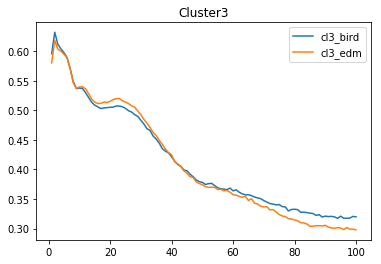

In [54]:
plt.plot(range(1,101),cl3_birdmean,range(1,101),cl3_mean)
plt.legend(['cl3_bird','cl3_edm'])
plt.title('Cluster3')

Text(0.5, 1.0, 'Cluster 4')

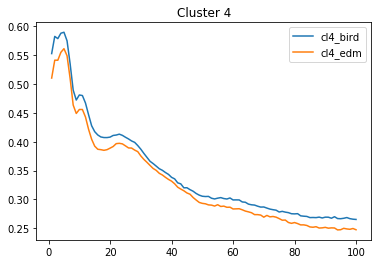

In [55]:
plt.plot(range(1,101),cl4_birdmean,range(1,101),cl4_mean)
plt.legend(['cl4_bird','cl4_edm'])
plt.title('Cluster 4')

Text(0.5, 1.0, 'Bird Song')

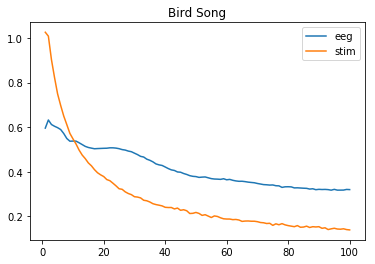

In [56]:
plt.plot(range(1,101),cl3_birdmean,range(1,101),samp3_mse)
plt.legend(['eeg','stim'])
plt.title('Bird Song')

In [57]:
##Sine Ted##
cl3_sine = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_sine.csv",header=None)
cl3_ted = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_ted.csv",header=None)
cl4_sine = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_sine.csv",header=None)
cl4_ted = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_ted.csv",header=None)

In [58]:
cl3_sinemse = []
cl3_tedmse = []
cl4_sinemse = []
cl4_tedmse = []

cl3_sineamp = []
cl3_tedamp = []
cl4_sinedamp = []
cl4_tedamp = []

for i in range(len(cl3_sine)):
    ts = cl3_sine.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl3_sineamp.append(amp)
    cl3_sinemse.append(multiscale_entropy( amp[0:halt], 3, None, 100))
    
for i in range(len(cl3_ted)):
    ts = cl3_ted.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl3_tedamp.append(amp)
    cl3_tedmse.append(multiscale_entropy( amp[0:halt], 3, None, 100))

for i in range(len(cl4_sine)):
    ts = cl4_sine.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl4_sineamp.append(amp)
    cl4_sinemse.append(multiscale_entropy( amp[0:halt], 3, None, 100))
    
for i in range(len(cl4_ted)):
    ts = cl4_ted.loc[i,:].values
    amp = np.abs(hilbert(ts))
    halt = int(len(ts)/4)
    cl4_tedamp.append(amp)
    cl4_tedmse.append(multiscale_entropy( amp[0:halt], 3, None, 100))

17:38:52
17:39:32
17:39:35
17:39:36
17:39:37
17:39:37
17:39:38
17:39:38
17:39:39
17:39:39
17:39:39
17:40:18
17:40:21
17:40:22
17:40:23
17:40:24
17:40:24
17:40:24
17:40:25
17:40:25
17:40:25
17:41:05
17:41:08
17:41:09
17:41:10
17:41:10
17:41:11
17:41:11
17:41:12
17:41:12
17:41:12
17:41:52
17:41:55
17:41:57
17:41:58
17:41:58
17:41:59
17:41:59
17:42:00
17:42:00
17:42:00
17:42:37
17:42:40
17:42:41
17:42:42
17:42:43
17:42:43
17:42:43
17:42:44
17:42:44
17:42:44
17:43:21
17:43:23
17:43:25
17:43:25
17:43:26
17:43:26
17:43:27
17:43:27
17:43:27
17:43:28
17:44:06
17:44:09
17:44:11
17:44:11
17:44:12
17:44:13
17:44:13
17:44:13
17:44:14
17:44:14
17:44:53
17:44:55
17:44:57
17:44:58
17:44:58
17:44:59
17:44:59
17:44:59
17:45:00
17:45:00
17:45:38
17:45:42
17:45:43
17:45:44
17:45:45
17:45:45
17:45:46
17:45:46
17:45:46
17:45:47
17:46:28
17:46:31
17:46:32
17:46:33
17:46:34
17:46:35
17:46:35
17:46:35
17:46:36
17:46:36
17:47:15
17:47:18
17:47:20
17:47:21
17:47:22
17:47:22
17:47:23
17:47:23
17:47:23
17:47:24
1

NameError: name 'cl4_sineamp' is not defined